# Assignment 5: Classification

## FIN 580
## Due: 11:59 am on Apr 29, 2025

In [ ]:
# Set up codes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
import random

import math

import warnings
warnings.filterwarnings('ignore')

---

### K-Nearest Neighbors (KNN) Algorithm

#### Overview:
- KNN is a non-parametric, instance-based learning algorithm used for classification and regression tasks.

#### Steps:
1. **Choose the value of K**: Determine the number of nearest neighbors to consider during prediction.
   
2. **Calculate distances**: Compute the distance between the new data point and all existing data points using a distance metric (e.g., Euclidean distance).
   
3. **Find K nearest neighbors**: Select the K data points with the shortest distances to the new data point.
   
4. **Majority voting (Classification)**: For classification tasks, assign the class label most frequently occurring among the K nearest neighbors to the new data point.
   
5. **Weighted voting (Classification, optional)**: Optionally, assign weights to the neighbors based on their distance to the new data point and perform weighted majority voting.
   
6. **Compute mean or median (Regression)**: For regression tasks, predict the target value of the new data point as the mean or median of the target values of its K nearest neighbors.

#### Key Components:
- **K**: Number of nearest neighbors to consider (a positive integer).
- **Distance Metric**: Measure of similarity between data points (e.g., Euclidean distance, Manhattan distance).

#### Advantages:
- Simple and intuitive.
- No assumptions about the underlying data distribution.
- Versatile and applicable to various types of data.

#### Limitations:
- Computationally expensive for large datasets.
- Sensitivity to the choice of K and the distance metric.
- Requires careful preprocessing and feature scaling.

#### Formulae:
- **Euclidean distance**: $d(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$
- **Manhattan distance**: $d(x, y) = \sum_{i=1}^{n} |x_i - y_i|$


## Understanding K-NN

### Play with this demo
http://vision.stanford.edu/teaching/cs231n-demos/knn/

This interactive demo is from Stanford, CS231-n. Play with it to build your intuition on K-nn.

![Screen%20Shot%202022-04-19%20at%2010.27.12%20AM.png](attachment:Screen%20Shot%202022-04-19%20at%2010.27.12%20AM.png)

## Problem 1. Curse of Dimensionality

### Problem 1.1 Understanding distance in high dimension

K-nn breaks down in high dimensions, and the phenomenon is commonly referred to as the curse of dimensionality (Bellman, 1961).

In this example, we will do some calculation and simulation experiment to help you understand the intuition.

Consider the nearest-neighbor procedure for inputs uniformly distributed
in a p-dimensional unit hypercube. Suppose we use a hypercubical neighborhood about a target point to capture a fraction r of the observations.

Since this corresponds to a fraction r of the unit volume, what will the length of
the expected edge $e_p \ (r)$ will be ?

<img src="knn.png" alt="Drawing" style="width: 300px;" align="center"/>




**Answer**:


$$
\mathbb{P}(\text{point in hypercube of edge length } e) = e^p = r
$$

$$
\Rightarrow \quad e_p(r) = r^{1/p}
$$


Now let's fix r at 0.1, and set p =[1,2,3,5,10,100] calculate $e_p\ (r)$ numerically, respectively. What conclusions can you make?

**Answer**:

In [ ]:
def e(r, p):
    return r**(1/p)

ps = [1,2,3,5,10,100]

for p in ps:
    print(f"e_{p}(0.1) = {round(e(r=0.1, p=p), 4)}")

e_1(0.1) = 0.1
e_2(0.1) = 0.3162
e_3(0.1) = 0.4642
e_5(0.1) = 0.631
e_10(0.1) = 0.7943
e_100(0.1) = 0.9772


As p increases, $e_p \ (r)$ increases drastically, and converges to 1 as p converges to infinity.

Now let's fix p at 10, and set r = [0.1,0.2,...,0.6], calculate $e_p \ (r)$ numerically, respectively. What conclusions can you draw?

**Answer**:

In [ ]:
rs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for r in rs:
    print(f"e_10_({r}) = {round(e(r=r, p=10), 4)}")

e_10_(0.1) = 0.7943
e_10_(0.2) = 0.8513
e_10_(0.3) = 0.8866
e_10_(0.4) = 0.9124
e_10_(0.5) = 0.933
e_10_(0.6) = 0.9502


As r increases, $e_p \ (r)$ increases and approaches 1.

Now let's formalize the above findings and run the following simulation experiment.
Save your results in a dataframe called "Distance" below.

Set the index as the sequence of r and columns the sequence of p.

In [ ]:
# Simulation experiment
p_seq = [1,2,3,5,10,100]
r = np.linspace(0,0.6,1000)

In [ ]:
##############################################################################
### TODO: Calculate the expected edge e_p(r)                              ###
##############################################################################
Distance = pd.DataFrame(
    {p: e(r, p) for p in p_seq},  # For each p in p_seq, apply e(r, p) across r
    index=r
)
print(Distance.head())
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

               1         2         3         5         10        100
0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
0.000601  0.000601  0.024507  0.084371  0.226839  0.476276  0.928508
0.001201  0.001201  0.034658  0.106301  0.260569  0.510460  0.934967
0.001802  0.001802  0.042448  0.121685  0.282580  0.531583  0.938765
0.002402  0.002402  0.049014  0.133931  0.299315  0.547097  0.941470


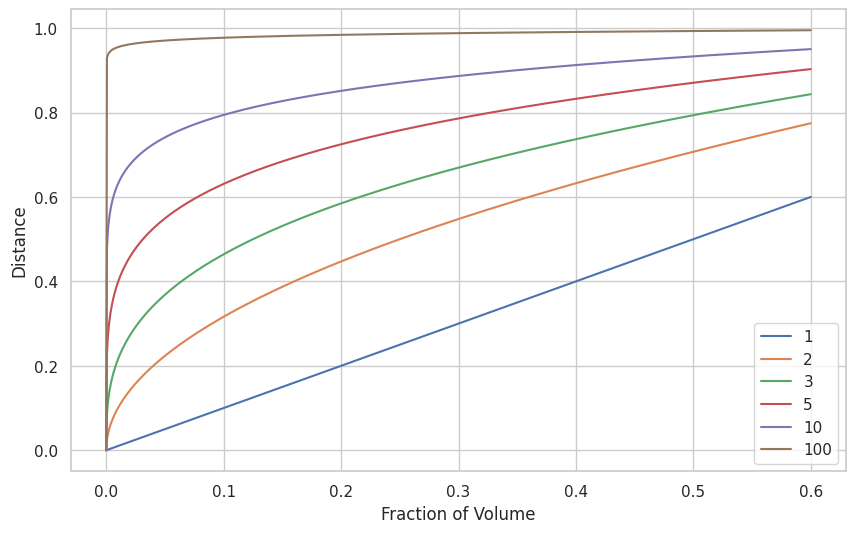

In [ ]:
# Visualize your results
Distance.plot(figsize = (10,6))
plt.ylabel('Distance')
plt.xlabel('Fraction of Volume')
plt.show()

### Problem 1.2 K-nn in high dimension

Recall the essence of K-nn:

1. We assume the point's label is similar to its neighbours.
2. We need to have a good measure of distance.

From Problem 1.1, we can see that in a unit hypercube, even though we want to cover a small fraction of its volume, the expected edge $e_r \ (p)$ is no longer small. Hence, the points we need to cover are no longer 'local'. This might result in the failure of K-nn.

Let's see this in the following simulation experiment.


### Experiment Setup

Suppose we have 1000 training examples $X_i$ generated uniformly on $[−1, 1]^p$. Assume that the true relationship between $X$ and $Y$ is

$$
Y = f(X) = e^{−8||X||^{2}}
$$

without any measurement error.

We use the 1-nn rule to predict $y_0$ at the test-point $X_{0} = 0$, and the true value of Y should be 1.

In [ ]:
##############################################################################
### TODO: Calculate Y based on x input.                                    ###
##############################################################################
def f(x):
    x = np.array(x)  # Make sure x is an array
    if x.ndim == 0:  # Scalar input
        norm_squared = x**2
    elif x.ndim == 1:  # Single vector
        norm_squared = np.sum(x**2)
    elif x.ndim == 2:  # Batch of vectors
        norm_squared = np.sum(x**2, axis=1)
    else:
        raise ValueError("Input x must be a scalar, 1D, or 2D array.")

    return np.exp(-8 * norm_squared)
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

### DGP

Run the following cell to generate the simulated data. You don't need to modify any codes here.

In [ ]:
def Generate_data(p):
    n_sample = 1000
    X = np.random.uniform(-1,1,(n_sample,p)).squeeze()

    return [f(x) for x in X]

Let's first visualize the results in 1-dimension and 2-dimension. After you finish the above codes, you can directly run the following codes. You don't need to modify any codes here.

### 2D Visualization for 1-dimensional X

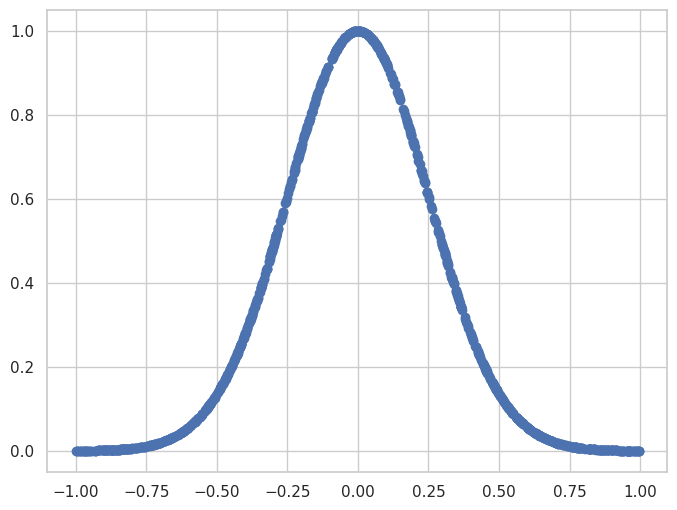

In [ ]:
p = 1
n_sample = 1000
X = np.random.uniform(-1,1,(n_sample,p)).squeeze()
y = [f(x) for x in X]

plt.figure(figsize = (8,6))
plt.plot(X,y,'o')

### 3D Visualization for 2-dimensional X

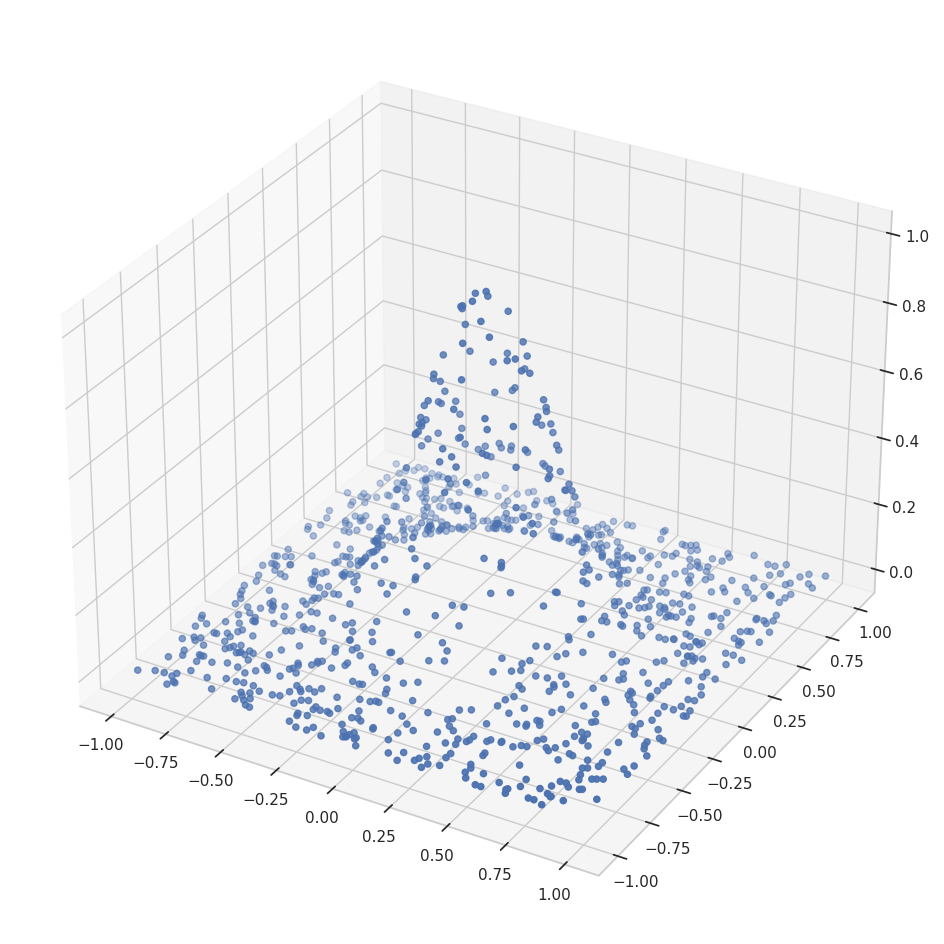

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

p = 2
X = np.random.uniform(-1,1,(n_sample,p)).squeeze()

fig = plt.figure(figsize = (12,12))
ax1 = plt.axes(projection='3d')

z = [f(x) for x in X]
x = X[:,0]
y = X[:,1]

ax1.scatter3D(x,y,z, cmap='Blues')
plt.show()

### K-nn and MSE

Now set the dimension $p = [1,2,...,20]$, run this DGP 500 times and claculate the MSE $\frac{1}{500}\sum_{i=1}^{500} (1 - \widehat{f}(x_i))^2$ for 1-nn for each $p$, where $x_i$ is the closest point to the origin in each simulation. Visulize the MSE with respect to dimension $p$, and make comments on this graph. What did you find?

In [ ]:
result = []
error = []

for p in range(1,21):
    for iter in range(500):
##############################################################################
### TODO: Calculate MSE for 1-nn, with different ps.                       ###
##############################################################################
        # Generate data
        X = np.random.uniform(-1, 1, (1000, p)).squeeze()

        # Compute distances to the origin
        if p == 0:  # in case p=0 (should not happen, but safe)
            dist = np.abs(X)
        elif p == 1 and X.ndim == 1:  # special handling if 1D array
            dist = np.abs(X)
        else:
            dist = np.linalg.norm(X, axis=1)

        # Find nearest neighbor
        idx_nn = np.argmin(dist)
        X_nn = X[idx_nn]

        # Predict using f(x_nn)
        pred = f(X_nn)

        # True value at the origin is 1
        mse = (1 - pred)**2

        # Save error
        error.append(mse)
    result.append(np.mean(error))
    error = []


##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

**Answer**:

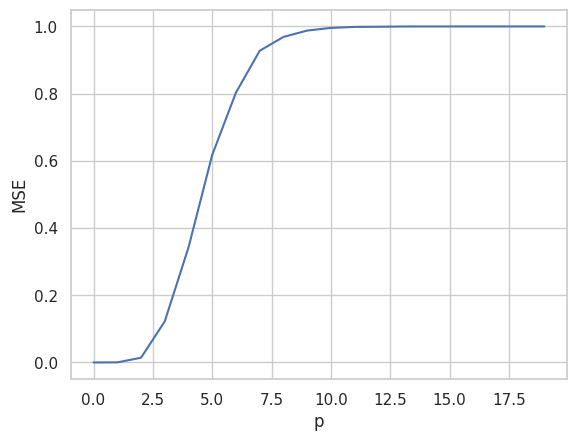

In [ ]:
plt.plot(np.arange(20),result)
plt.xlabel('p')
plt.ylabel('MSE')
plt.show()

For small dimension p, the MSE is close to 0, indicating that this algorithm is effecient. As the dimension p increases, the MSE of 1-NN prediction grows rapidly and saturates near 1. This demonstrates the curse of dimensionality: in high dimensions, even the nearest neighbor is distant from the query point, making local approximation methods like k-NN unreliable.

## Problem 2. Tree methods in Classification

In this exercise, we will revisit the moon shape, circle shape, and the balanced linearly separable data in class. Now use CART and Random Forest to redo the classification task and visualize the decision boundary. Compare the results with K-nn.

### Problem 2.1 Data Generating Processs (DGP)

Run the following codes to get the moon shape, circle shape, and balanced linearly separable data. They are stored in a dictionary structure named 'datasets'.

You don't need to modify any codes here.

In [ ]:
from sklearn.datasets import make_moons, make_circles,make_blobs

h = 0.02  # step size in the mesh

n_samples = 1500

datasets = [
    make_moons(n_samples=n_samples,noise=0.05, random_state=0),
    make_circles(n_samples=n_samples,noise=0.05, factor=0.5, random_state=1),
    make_blobs(n_samples=n_samples, random_state=8,centers=2,center_box = (-4,4))

]

### Problem 2.2 Initialize the classifiers

Run the following codes to initialize the K-nn, CART, and Random Forest classifier. Store them in a dictionary structure named 'classifiers'.

You don't need to modify any codes here.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

names = ["Nearest Neighbors","Decision Tree","Random Forest"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
]

### Problem 2.3 Model training

Finish the codes in the iteration and run the below cells to visualize the decision boundary.


(1) Split the data into training and test set.
(With variable name 'X_train', 'X_test', 'y_train', 'y_test', respectively.)

(2) Train the models.

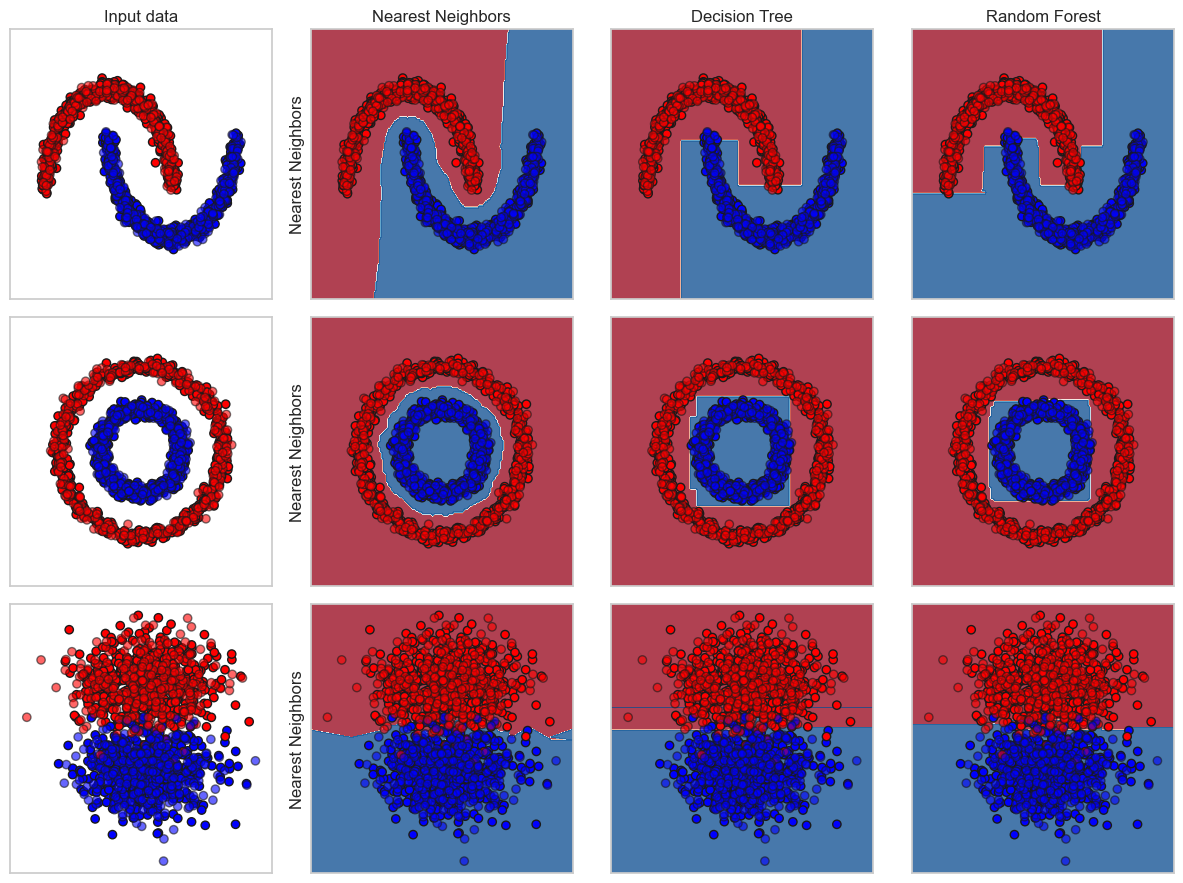

In [ ]:
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
# Set up the plotting
figure = plt.figure(figsize=(12, 9))

i = 1
for dataset in datasets:
    X, y = dataset

    # 1. Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

    # Plot training and testing points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    if i == 1:
        ax.set_title("Input data")
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        # 2. Train the model
        clf.fit(X_train, y_train)

        # plot the decision boundary
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot training and testing points again
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if i % (len(classifiers) + 1) == 2:
            ax.set_ylabel(name)
        if i <= len(classifiers) + 1:
            ax.set_title(name)
        i += 1

plt.tight_layout()
plt.show()

### Problem 2.4 Findings

Based on the decision boundary you have generated in the above exercise, what conclusion can you make?


**Answer**:

* K-Nearest Neighbors is most effective for non-linear datasets like moons and circles.

* Random Forest improves upon the decision tree by averaging multiple models, resulting in smoother and more robust boundaries. It performs better than a single tree and is more resistant to noise, although it still lacks the fine flexibility of KNN in capturing intricate shapes.

* Decision Tree creates blocky, axis-aligned boundaries that fail to capture the curved patterns in the data. While it handles simpler separations reasonably well, its performance deteriorates on non-linear or noisy datasets due to its limited structure.



### Problem 2.5 SVM

Can you implement an approporiate SVM for comparison? Draw the decision boundary and comment.

**Answer**:

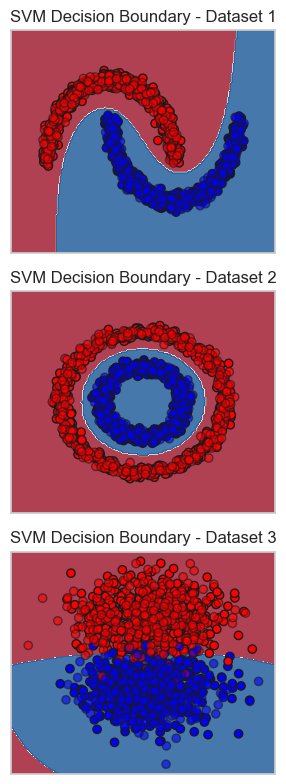

In [ ]:
from sklearn.svm import SVC
# Create SVM model
clf = SVC(kernel='rbf', gamma='auto', C=1.0)

# Plotting
figure = plt.figure(figsize=(3,8))

for i, dataset in enumerate(datasets, 1):
    X, y = dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    ax = plt.subplot(3, 1, i)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"SVM Decision Boundary - Dataset {i}")

plt.tight_layout()
plt.show()


The SVM with RBF kernel generates smooth, non-linear decision boundaries, which are particularly effective for the moons and circles datasets. It generalizes well and is less prone to overfitting compared to k-NN. On the blobs dataset, it correctly finds a linear-looking separation, behaving similarly to the best-performing Random Forest model. Overall, SVM provides a strong balance between flexibility and robustness, making it a top performer across all three datasets.

## Problem 3. K-NN Regressions for Face Completion

### K-nn in regression:

K-nn is also widely applicable in regression. See the following explaination.

**What we want in theory**:

Recall in the regression setting (not necessarily linear) with square loss, the optimal f that minimize:
$$
L(Y,f(X)) = [Y-f(X)]^2
$$

is $f_{opt} = \mathbb{E}(Y|X=x)$.

**What we do in practice:**

Unfortunately, we can't in general use this formula. And in linear setting, we have this assumption:

$$
\mathbb{E}(Y|X=x) = x'\beta
$$


This is so-called a *parametric* method.


As for k-NN regression, it estimates $\mathbb{E}(Y|X=x)$ based on local averaging, it's a *non-parametric* method.

$$
\hat{Y}(x) = \hat{E}(Y | X = x) = \frac{1}{k}\sum_{i = 1}^ky(X_{N_i{(x)}})
$$



### Problem 3.1 Fit the K-nn regression

Condiser the following DGP: $y = sin(x) + 0.2 \times \varepsilon$ where $\varepsilon$ is the standard Gaussian noise. Run the following cell and you don't need to modify any codes here.

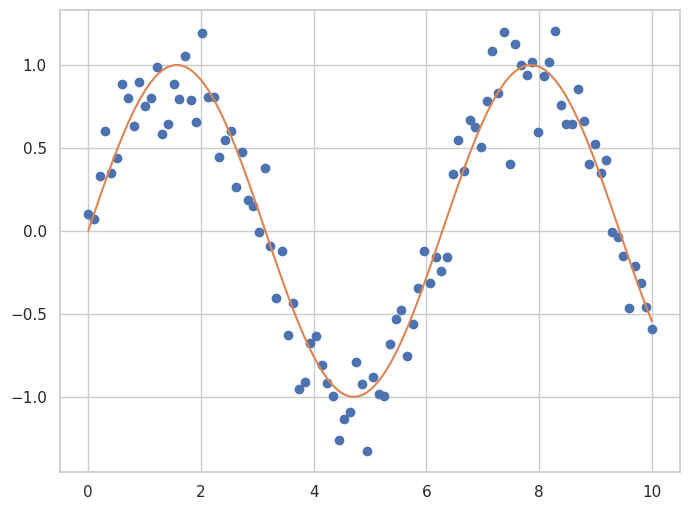

In [ ]:
# DPG
np.random.seed(42)

N = 100
noise = 0.2

# Generate y = sin(x)
x = np.linspace(0, N, N, endpoint=True) / 10
y = np.sin(x)

# Add noise term
y += noise * np.random.normal(0, 1, N)

plt.figure(figsize = (8,6))
plt.plot(x, y, 'o')
plt.plot(x, np.sin(x))
plt.show()

Please fit a K-nn estimator to this dataset and visualize the fitted regression line with different Ks. Finish the codes in Knn_experiment.py and run the folllowing cells.

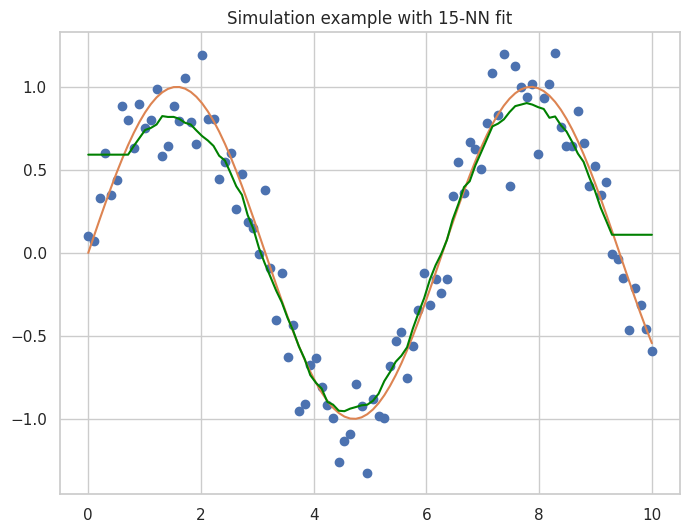

In [ ]:
# Perform K-nn regression
from Knn_regression_2025 import *


# Try to play with different K
k = 15

Knn_visualize(x,y,k)

Based on the visualization results, can you answer the following questions?

+ Is K-nn regression linear?
+ As K increases, does the fitted regression line become smoother or not?

+ K-nn regression is not linear because it does not learn a global linear relationship. Instead, it makes predictions by averaging local neighbor patterns.


+ As K increases, the fitted regression line become smoother, since one deviating point has less effect on the prediction by averaging, but when K is too large, the fitted value will become globally constant, and lack prediction power.

### Problem 3.2 Face completion

In this exerceise, we compare different methods on the task of face completion. The goal is to predict the lower half of a face given its upper half using different algorithm.

### Data preprocessing

In this dataset, we have 40 people each with 10 different facial photographs (400 graphs in total). And each graph's pixels are in 64 $\times$ 64 dimension.


Run the following cells and load the face dataset. You can see the data descriprion as below, and you don't need to modify any codes here.



+ data   : flattened vector of these images, dimension 400 $\times$ 4096.
+ target : label of each person, from 0-39, 40 classes in total.

In [ ]:
# Load the faces datasets

from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

data, targets = fetch_olivetti_faces(return_X_y=True)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
# Train test set split
# Use the first 30 people as our training set, and the last 10 as ouur testing data.

train = data[targets < 30]
test = data[targets >= 30]

In [ ]:
# Choose 5 graphs from the total test set for visualization purpose. These are five full faces.

n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces,))
test = test[face_ids, :]

Run the following cells to visualize the true face.

In [ ]:
# Seperate each graph into the upper half and lower half.

n_pixels = data.shape[1]
X_train = train[:, : (n_pixels + 1) // 2]
y_train = train[:, n_pixels // 2 :]

X_test = test[:, : (n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2 :]

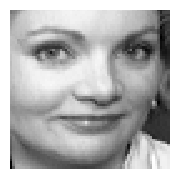

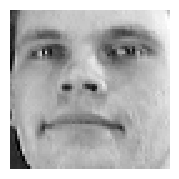

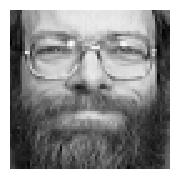

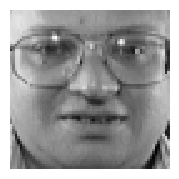

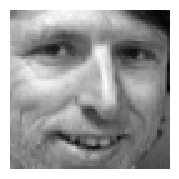

In [ ]:
image_shape = (64, 64)
for i in range(1,6):
    plt.figure(figsize = (12,12))
    plt.subplot(5,1,i)
    true_face = np.hstack((X_test[i-1], y_test[i-1]))
    plt.axis("off")
    plt.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

### Model training

In this section, you will compare the results of K-nn, linear regression, and ridge. Note that this is a multi-dimensional regression problem, where each pixel in the lower half the image is a y variable that you need run regression with. In other words, the y variable is a matrix.

In [ ]:
# Fit estimators and store the information in a dictionary structure dataframe.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

ESTIMATORS = {
    # "K-nn": KNeighborsRegressor(),
    # "Linear regression": LinearRegression(),
    # "Ridge": RidgeCV()
    "K-nn": KNeighborsRegressor(n_neighbors=5, weights='distance'),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(alphas=[1e-4, 0.001, 0.01, 0.1, 1], cv=5)
}

y_test_predict = dict()

Finish your codes in the following cells. You need to finish the training procedure for K-nn, linear regression and ridge. And use these models to get OOS prediction.

In [ ]:
##############################################################################
### TODO: Fit K-nn, linear regression and ridge, and get OOS prediction    ###
##############################################################################

for name, estimator in ESTIMATORS.items():
  estimator.fit(X_train, y_train)
  y_pred = estimator.predict(X_test)
  y_test_predict[name] = y_pred
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################


### Visualization

Run the following cells to visualize the facial prediction. You don't need to modify any codes here.

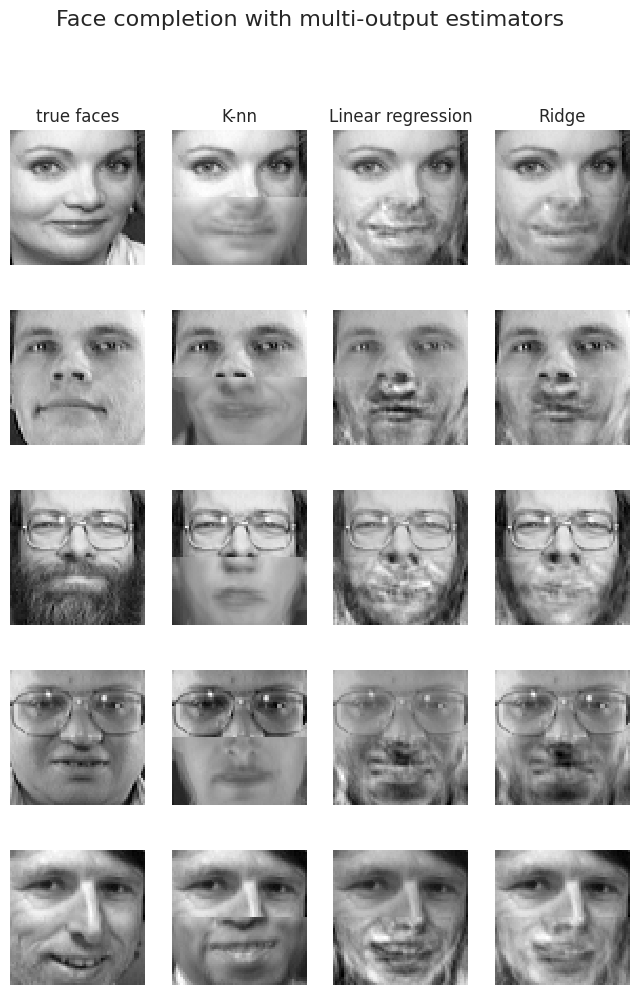

In [ ]:
# Plot the completed faces

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j, title=est)

        sub.axis("off")
        sub.imshow(
            completed_face.reshape(image_shape),
            cmap=plt.cm.gray,
            interpolation="nearest",
        )

plt.show()